In [ ]:
#!pip install --upgrade cupy-cuda112==8.5.0

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cupy as cp
import math
from time import time

In [ ]:
#@title CustomKernel
import cupy as cp
import torch

@cp.util.memoize(for_each_device=True)
def cunnex(func_name, func_body):
  return cp.cuda.compile_with_cache(func_body).get_function(func_name)

class Stream:
  def __init__(self, ptr):
    self.ptr = ptr
  
class CustomKernel:
  def __init__(self):
    self._use_torch_in_cupy_malloc()
    self.stream = Stream(torch.cuda.current_stream().cuda_stream)

  @staticmethod
  def _torch_alloc(size):
    device = cp.cuda.Device().id
    tensor = torch.empty(size, dtype=torch.uint8, device=device)
    return cp.cuda.MemoryPointer(
        cp.cuda.UnownedMemory(tensor.data_ptr(), size, tensor), 0)

  def _use_torch_in_cupy_malloc(self):
    cp.cuda.set_allocator(self._torch_alloc)

  def _compile_kernel_str(
      self,
      kernel,
      name,
      options=(),
      backend="nvrtc",
      max_dynamic_smem=None
    ):
    fn = cp.RawKernel(
      kernel,
      name,
      options=options,
      backend=backend,
    )
    if max_dynamic_smem:
      fn.max_dynamic_shared_size_bytes = max_dynamic_smem
    return fn

In [ ]:
#@title bmm_helpers.cu
kernel = """
#define _VOLATILE_  

#define likely(x)      __builtin_expect(!!(x), 1)
#define unlikely(x)    __builtin_expect(!!(x), 0)
#define load(x)        __ldcg(x)
#define store(x, value) __stcs(x, value)

typedef long long ll_t;
typedef unsigned long long ull_t;

typedef struct __builtin_align__(32) {
  float s0, s1, s2, s3, s4, s5, s6, s7;
} _float8;

typedef union {
  _float8 f8;
  float val[8];
} float8;

__device__ void madd(
  float a,
  float b,
  float &c
) {
  c = fmaf(a, b, c);
}

__device__ void squared_l2(
  float a,
  float b,
  float &c
){
  float dif = a - b;
  c = fmaf(dif, dif, c);
}

__device__ void negative_squared_l2(
  float a,
  float b,
  float &c
){
  float dif = a - b;
  c = fmaf(-dif, dif, c);
}

__device__ void l1(
  float a,
  float b,
  float &c
){
  c += fabsf(a - b);
}

__device__ void negative_l1(
  float a,
  float b,
  float &c
){
  c -= fabsf(a - b);
}

__device__ void thread_matmul_v4(
  _VOLATILE_ float aSM[8][128+4],
  _VOLATILE_ float bSM[8][128+4],
  float8 cCache[8],
  int vx, int vy
) {
  float aCache1[8];
  float aCache2[8];
  #pragma unroll
  for (int mi=0; mi<8; mi++){
    aCache1[mi] = aSM[0][8*vy + mi];
  }

  #pragma unroll
  for (int ki=0; ki<8; ki++){
    int is_odd = ki & 1;
    if (is_odd == 0){
      if (likely(ki < 7)){
        #pragma unroll
        for (int mi=0; mi<8; mi++){
          aCache2[mi] = aSM[ki+1][8*vy + mi];
        }
      }
      #pragma unroll
      for (int ni=0; ni<8; ni++){
        float b = bSM[ki][vx/4 + 8*vx + ni];
        #pragma unroll
        for (int mi=0; mi<8; mi++){
          float a = aCache1[mi];
          cCache[mi].val[ni] = fmaf(a, b, cCache[mi].val[ni]);
        }
      }
    } else {
      if (likely(ki < 7)){
        #pragma unroll
        for (int mi=0; mi<8; mi++){
          aCache1[mi] = aSM[ki+1][8*vy + mi];
        }
      }
      #pragma unroll
      for (int ni=0; ni<8; ni++){
        float b = bSM[ki][vx/4 + 8*vx + ni];
        #pragma unroll
        for (int mi=0; mi<8; mi++){
          float a = aCache2[mi];
          cCache[mi].val[ni] = fmaf(a, b, cCache[mi].val[ni]);
        }
      }
    }
  }
}

__device__ void thread_matmul_16_v3(
  _VOLATILE_ float aSM[16][128+4],
  _VOLATILE_ float bSM[16][128+4],
  float8 cCache[8],
  int vx, int vy
) {
  float aCache[8];

  #pragma unroll
  for (int ki=0; ki<16; ki++){
    #pragma unroll
    for (int mi=0; mi<8; mi++){
      aCache[mi] = aSM[ki][8*vy + mi];
    }
    #pragma unroll
    for (int ni=0; ni<8; ni++){
      float b = bSM[ki][vx/4 + 8*vx + ni];
      #pragma unroll
      for (int mi=0; mi<8; mi++){
        float a = aCache[mi];
        __DISTANCE_FN__(a, b, cCache[mi].val[ni]);
      }
    }
  }
}

__device__ void thread_matmul_v3(
  _VOLATILE_ float aSM[8][128+4],
  _VOLATILE_ float bSM[8][128+4],
  float8 cCache[8],
  int vx, int vy
) {
  float aCache[8];

  #pragma unroll
  for (int ki=0; ki<8; ki++){
    #pragma unroll
    for (int mi=0; mi<8; mi++){
      aCache[mi] = aSM[ki][8*vy + mi];
    }
    #pragma unroll
    for (int ni=0; ni<8; ni++){
      float b = bSM[ki][vx/4 + 8*vx + ni];
      #pragma unroll
      for (int mi=0; mi<8; mi++){
        float a = aCache[mi];
        __DISTANCE_FN__(a, b, cCache[mi].val[ni]);
      }
    }
  }
}

__device__ void init_cCache(
  float8 cCache[8]
) {
  #pragma unroll
  for (int i=0; i<8; i++){
    #pragma unroll
    for (int j=0; j<8; j++){
      cCache[i].val[j] = 0.f;
    }
  }
}


// Unsafe
__device__ void write_c(
  float8 cCache[8],
  float* C,
  int gStartx, int gStarty,
  int vx, int vy, int bid,
  int M, int N
) {
  #pragma unroll
  for (int i=0; i<8; i++){
    int iM = gStarty + vy*8 + i;
    if (likely(iM < M)){
      int iN_start = gStartx + vx*8;
      reinterpret_cast<float8*>(C + (bid)*M*N + (iM)*N + (iN_start))[0] = cCache[i];
      /*
      if (likely(iN_start + 7 < N)){
        reinterpret_cast<float8*>(C + (bid)*M*N + (iM)*N + (iN_start))[0] = cCache[i];
      } else {
        #pragma unroll
        for (int j=0; j<8; j++){
          int iN = iN_start + j;
          if (iN < N){
            C[(bid)*M*N + (iM)*N + (iN)] = cCache[i].val[j];
          }
        }
      }
      */
    }
  }
}

__device__ void write_c_v3(
  float8 cCache[8],
  float* C,
  int gStartx, int gStarty,
  int vx, int vy, int bid,
  int M, int N
) {
  __shared__ volatile float cSM[16][128];
  #pragma unroll
  for (int mi=0; mi<8; mi++){
    int iM = gStarty + vy*8 + mi;
    // Store 1 row from cCache to cSM
    if (iM < M){
      #pragma unroll
      for (int ni=0; ni<8; ni++){
        cSM[vy][vx*8 + ni] = cCache[mi].val[ni];
      }
      // Store to C
      #pragma unroll
      for (int ni=0; ni<8; ni++){
        int iN = gStartx + 16*ni + vx;
        if (iN < N){
          float cVal = cSM[vy][16*ni + vx];
          store(C+(bid)*M*N + (iM)*N + (iN), cVal);
        }
      }
    }
  } 
}

__device__ void load_ab_nn(
  const float* A,
  const float* B,
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4],
  int bid, int gStartx, int gStarty, int gStartk,
  int M, int N, int K
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  int iKA = gStartk + dx;
  int iKB = gStartk + wy;
  #pragma unroll
  for (int i=0; i<4; i++){
    int iM = gStarty + dy + i*32;
    int iN = gStartx + wx + i*32;
    if (likely(iM < M)){
      if (likely(iKA < K)){
        aBuffer1[i] = load(A + (bid)*M*K + (iM)*K + (iKA));
      } else {
        aBuffer1[i] = 0.f;
      }
      if (likely(iKA+8 < K)){
        aBuffer2[i] = load(A + (bid)*M*K + (iM)*K + (iKA+8));
      } else {
        aBuffer2[i] = 0.f;
      }
    }
    if (likely(iN < N)){
      if (likely(iKB < K)){
        bBuffer1[i] = load(B + (bid)*N*K + (iKB)*N + (iN));
      } else {
        bBuffer1[i] = 0.f;
      }
      if (likely(iKB+8 < K)){
        bBuffer2[i] = load(B + (bid)*N*K + (iKB+8)*N + (iN));
      } else {
        bBuffer2[i] = 0.f;
      }
    }
  }
}

__device__ void load_ab_tt(
  const float* A,
  const float* B,
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4],
  int bid, int gStartx, int gStarty, int gStartk,
  int M, int N, int K
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  int iKA = gStartk + wy;
  int iKB = gStartk + dx;
  #pragma unroll
  for (int i=0; i<4; i++){
    int iM = gStarty + wx + i*32;
    int iN = gStartx + dy + i*32;
    if (likely(iM < M)){
      if (likely(iKA < K)){
        aBuffer1[i] = load(A + (bid)*M*K + (iKA)*M + (iM));
      } else {
        aBuffer1[i] = 0.f;
      }
      if (likely(iKA+8 < K)){
        aBuffer2[i] = load(A + (bid)*M*K + (iKA+8)*M + (iM));
      } else {
        aBuffer2[i] = 0.f;
      }
    }
    if (likely(iN < N)){
      if (likely(iKB < K)){
        bBuffer1[i] = load(B + (bid)*N*K + (iN)*K + (iKB));
      } else {
        bBuffer1[i] = 0.f;
      }
      if (likely(iKB+8 < K)){
        bBuffer2[i] = load(B + (bid)*N*K + (iN)*K + (iKB+8));
      } else {
        bBuffer2[i] = 0.f;
      }
    }
  }
}

__device__ void load_ab_nt(
  const float* A,
  const float* B,
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4],
  int bid, int gStartx, int gStarty, int gStartk,
  int M, int N, int K
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  int iKA = gStartk + dx;
  int iKB = gStartk + dx;
  #pragma unroll
  for (int i=0; i<4; i++){
    int iM = gStarty + dy + i*32;
    int iN = gStartx + dy + i*32;
    if (likely(iM < M)){
      if (likely(iKA < K)){
        aBuffer1[i] = load(A + (bid)*M*K + (iM)*K + (iKA));
      } else {
        aBuffer1[i] = 0.f;
      }
      if (likely(iKA+8 < K)){
        aBuffer2[i] = load(A + (bid)*M*K + (iM)*K + (iKA+8));
      } else {
        aBuffer2[i] = 0.f;
      }
    }
    if (likely(iN < N)){
      if (likely(iKB < K)){
        bBuffer1[i] = load(B + (bid)*N*K + (iN)*K + (iKB));
      } else {
        bBuffer1[i] = 0.f;
      }
      if (likely(iKB+8 < K)){
        bBuffer2[i] = load(B + (bid)*N*K + (iN)*K + (iKB+8));
      } else {
        bBuffer2[i] = 0.f;
      }
    }
  }
}

__device__ void load_ab_tn(
  const float* A,
  const float* B,
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4],
  int bid, int gStartx, int gStarty, int gStartk,
  int M, int N, int K
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  int iKA = gStartk + wy;
  int iKB = gStartk + wy;
  #pragma unroll
  for (int i=0; i<4; i++){
    int iM = gStarty + wx + i*32;
    int iN = gStartx + wx + i*32;
    if (likely(iM < M)){
      if (likely(iKA < K)){
        aBuffer1[i] = load(A + (bid)*M*K + (iKA)*M + (iM));
      } else {
        aBuffer1[i] = 0.f;
      }
      if (likely(iKA+8 < K)){
        aBuffer2[i] = load(A + (bid)*M*K + (iKA+8)*M + (iM));
      } else {
        aBuffer2[i] = 0.f;
      }
    }
    if (likely(iN < N)){
      if (likely(iKB < K)){
        bBuffer1[i] = load(B + (bid)*N*K + (iKB)*N + (iN));
      } else {
        bBuffer1[i] = 0.f;
      }
      if (likely(iKB+8 < K)){
        bBuffer2[i] = load(B + (bid)*N*K + (iKB+8)*N + (iN));
      } else {
        bBuffer2[i] = 0.f;
      }
    }
  }
}

__device__ void buffer2smem_nn(
  _VOLATILE_ float aSM1[8][128+4],
  _VOLATILE_ float aSM2[8][128+4],
  _VOLATILE_ float bSM1[8][128+4],
  _VOLATILE_ float bSM2[8][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM1[dx][dy+i*32] = aBuffer1[i];
    bSM1[wy][wx+i*32+i] = bBuffer1[i];
    aSM2[dx][dy+i*32] = aBuffer2[i];
    bSM2[wy][wx+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_tt(
  _VOLATILE_ float aSM1[8][128+4],
  _VOLATILE_ float aSM2[8][128+4],
  _VOLATILE_ float bSM1[8][128+4],
  _VOLATILE_ float bSM2[8][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM1[wy][wx+i*32] = aBuffer1[i];
    aSM2[wy][wx+i*32] = aBuffer2[i];
    bSM1[dx][dy+i*32+i] = bBuffer1[i];
    bSM2[dx][dy+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_nt(
  _VOLATILE_ float aSM1[8][128+4],
  _VOLATILE_ float aSM2[8][128+4],
  _VOLATILE_ float bSM1[8][128+4],
  _VOLATILE_ float bSM2[8][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM1[dx][dy+i*32] = aBuffer1[i];
    aSM2[dx][dy+i*32] = aBuffer2[i];
    bSM1[dx][dy+i*32+i] = bBuffer1[i];
    bSM2[dx][dy+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_tn(
  _VOLATILE_ float aSM1[8][128+4],
  _VOLATILE_ float aSM2[8][128+4],
  _VOLATILE_ float bSM1[8][128+4],
  _VOLATILE_ float bSM2[8][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM1[wy][wx+i*32] = aBuffer1[i];
    aSM2[wy][wx+i*32] = aBuffer2[i];
    bSM1[wy][wx+i*32+i] = bBuffer1[i];
    bSM2[wy][wx+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_16_nn(
  _VOLATILE_ float aSM[16][128+4],
  _VOLATILE_ float bSM[16][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM[dx][dy+i*32] = aBuffer1[i];
    aSM[dx+8][dy+i*32] = aBuffer2[i];
    bSM[wy][wx+i*32+i] = bBuffer1[i];
    bSM[wy+8][wx+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_16_tt(
  _VOLATILE_ float aSM[16][128+4],
  _VOLATILE_ float bSM[16][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM[wy][wx+i*32] = aBuffer1[i];
    aSM[wy+8][wx+i*32] = aBuffer2[i];
    bSM[dx][dy+i*32+i] = bBuffer1[i];
    bSM[dx+8][dy+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_16_nt(
  _VOLATILE_ float aSM[16][128+4],
  _VOLATILE_ float bSM[16][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM[dx][dy+i*32] = aBuffer1[i];
    aSM[dx+8][dy+i*32] = aBuffer2[i];
    bSM[dx][dy+i*32+i] = bBuffer1[i];
    bSM[dx+8][dy+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_16_tn(
  _VOLATILE_ float aSM[16][128+4],
  _VOLATILE_ float bSM[16][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM[wy][wx+i*32] = aBuffer1[i];
    aSM[wy+8][wx+i*32] = aBuffer2[i];
    bSM[wy][wx+i*32+i] = bBuffer1[i];
    bSM[wy+8][wx+i*32+i] = bBuffer2[i];
  }
}
"""
with open("bmm_helpers.cu", "w") as f:
  f.write(kernel)

In [ ]:
#@title MinBMM Kernel
kernel = """
__device__ __forceinline__ float atomicMin(float *address, float val)
{
  int ret = __float_as_int(*address);
  while(val < __int_as_float(ret))
  {
    int old = ret;
    if((ret = atomicCAS((int *)address, old, __float_as_int(val))) == old)
      break;
  }
  return __int_as_float(ret);
}

__device__ void min_dim_1(
  float8 cCache[8],
  _VOLATILE_ float valSM[16][128+4],
  _VOLATILE_ float idxSM[16][128+4],
  float* values,
  ll_t* indices,
  int gStartx, int gStarty, int tid, int bid,
  int M, int N
){
  int vx = tid % 16;
  int vy = tid / 16;

  #pragma unroll
  for (int ni = 0; ni < 8; ni++){
    // initialize with first value

    float value;
    if (likely(gStarty + vy*8 < M)){
      value = cCache[0].val[ni];
    } else {
      value = INFINITY;
    }
    float index = vy*8;

    // Reduce within thread
    #pragma unroll
    for (int mi = 1; mi < 8; mi++){
      int iM = gStarty + vy*8 + mi;
      float temp;
      if (likely(iM < M)){
        temp = cCache[mi].val[ni];
      } else {
        temp = INFINITY;
      }
      if (temp < value){
        value = temp;
        index = vy*8 + mi;
      }
    }

    // Store reduced values and indices in shared memory
    valSM[vy][vx * 8 + ni] = value;
    idxSM[vy][vx * 8 + ni] = index;
  }
  __syncthreads();

  // first 128 threads do block wise reduction
  if (tid < 128){
    float value = valSM[0][tid];
    float index = idxSM[0][tid];
    
    #pragma unroll
    for (int i=1; i<16; i++){
      float temp = valSM[i][tid];
      if (temp < value){
        value = temp;
        index = idxSM[i][tid];
      }
    }
    
    // global reduction
    int iN = gStartx + tid;
    if (iN < N){
      atomicMin(values + (bid) * N + iN, value);
      if (value <= values[(bid) * N + iN]){
        indices[(bid) * N + iN] = ll_t(index) + gStarty;
      }
    }
    /*
    */
  }
}

__device__ void min_dim_2(
  float8 cCache[8],
  _VOLATILE_ float valSM[16][128+4],
  _VOLATILE_ float idxSM[16][128+4],
  float* values,
  ll_t* indices,
  int gStartx, int gStarty, int tid, int bid,
  int M, int N
){
  int vx = tid % 16;
  int vy = tid / 16;

  #pragma unroll
  for (int mi = 0; mi < 8; mi++){
    // initialize with first value
    float value;
    if (likely(gStartx + vx*8 < N)){
      value = cCache[mi].val[0];
    } else {
      value = INFINITY;
    }
    float index = vx*8;

    // Reduce within thread
    #pragma unroll
    for (int ni = 1; ni < 8; ni++){
      int iN = gStartx + vx*8 + ni;
      float temp;
      if (likely(iN < N)){
        temp = cCache[mi].val[ni];
      } else {
        temp = INFINITY;
      }
      if (temp < value){
        value = temp;
        index = vx*8 + ni;
      }
    }

    // Store reduced values and indices in shared memory
    valSM[vx][vy * 8 + mi] = value;
    idxSM[vx][vy * 8 + mi] = index;
  }
  __syncthreads();

  // first 128 threads do block-wise reduction
  if (tid < 128){
    float value = valSM[0][tid];
    float index = idxSM[0][tid];
    #pragma unroll
    for (int i = 1; i < 16; i++){
      float temp = valSM[i][tid];
      if (temp < value){
        value = temp;
        index = idxSM[i][tid];
      }
    }

    // global reduction
    int iM = gStarty + tid;
    if (iM < M){
      atomicMin(values + (bid) * M + iM, value);
      if (value <= values[(bid) * M + iM]){
        indices[(bid) * M + iM] = ll_t(index) + gStartx;
      }
    }
  }
}

extern "C"
__global__ void min_bmm_tn(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* __restrict__ values,
  ll_t* __restrict__ indices,
  int M, int N, int K, int DIM
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM[16][128+4];
  __shared__ _VOLATILE_ float bSM[16][128+4];

  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  #pragma unroll
  load_ab_tn(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;

    buffer2smem_16_tn(
      aSM, bSM,
      aBuffer1, aBuffer2, 
      bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_tn(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    thread_matmul_16_v3(aSM, bSM, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }

  // Reduce along DIM
  if (DIM == 1){
    min_dim_1(
      cCache, aSM, bSM, values, indices,
      gStartx, gStarty, tid, bid, M, N);
  } else if (DIM == 2){
    min_dim_2(
      cCache, aSM, bSM, values, indices,
      gStartx, gStarty, tid, bid, M, N);
  }
}

extern "C"
__global__ void min_bmm_nt(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* __restrict__ values,
  ll_t* __restrict__ indices,
  int M, int N, int K, int DIM
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM[16][128+4];
  __shared__ _VOLATILE_ float bSM[16][128+4];

  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  #pragma unroll
  load_ab_nt(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;

    buffer2smem_16_nt(
      aSM, bSM,
      aBuffer1, aBuffer2,
      bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_nt(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    thread_matmul_16_v3(aSM, bSM, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }

  // Reduce along DIM
  if (DIM == 1){
    min_dim_1(
      cCache, aSM, bSM, values, indices,
      gStartx, gStarty, tid, bid, M, N);
  } else if (DIM == 2){
    min_dim_2(
      cCache, aSM, bSM, values, indices,
      gStartx, gStarty, tid, bid, M, N);
  }
}

extern "C"
__global__ void min_bmm_nn(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* __restrict__ values,
  ll_t* __restrict__ indices,
  int M, int N, int K, int DIM
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM[16][128+4];
  __shared__ _VOLATILE_ float bSM[16][128+4];

  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  load_ab_nn(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;

    buffer2smem_16_nn(
      aSM, bSM,
      aBuffer1, aBuffer2,
      bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_nn(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    thread_matmul_16_v3(aSM, bSM, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }

  // Reduce along DIM
  if (DIM == 1){
    min_dim_1(
      cCache, aSM, bSM, values, indices,
      gStartx, gStarty, tid, bid, M, N);
  } else if (DIM == 2){
    min_dim_2(
      cCache, aSM, bSM, values, indices,
      gStartx, gStarty, tid, bid, M, N);
  }
}

extern "C"
__global__ void min_bmm_tt(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* __restrict__ values,
  ll_t* __restrict__ indices,
  int M, int N, int K, int DIM
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM[16][128+4];
  __shared__ _VOLATILE_ float bSM[16][128+4];

  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  #pragma unroll
  load_ab_tt(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;

    buffer2smem_16_tt(
      aSM, bSM,
      aBuffer1, aBuffer2,
      bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_tt(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    thread_matmul_16_v3(aSM, bSM, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }

  // Reduce along DIM
  if (DIM == 1){
    min_dim_1(
      cCache, aSM, bSM, values, indices,
      gStartx, gStarty, tid, bid, M, N);
  } else if (DIM == 2){
    min_dim_2(
      cCache, aSM, bSM, values, indices,
      gStartx, gStarty, tid, bid, M, N);
  }
}
"""
with open("MinBMMCUDA.cu", "w") as f:
  f.write(kernel)

In [ ]:
#@title MinBMM
import torch
import cupy as cp
import numpy as np
import math

class MinBMMCUDA(CustomKernel): 
  def __init__(self, m=None, n=None, k=None, patch_m=4, patch_n=4, distance="inner"):
    super(MinBMMCUDA, self).__init__()
    self.m = m
    self.n = n
    self.k = k
    self.patch_m = patch_m
    self.patch_n = patch_n
    if distance == "inner":
      dist_fn = "madd"
    elif distance in ["l2", "euclidean"]:
      dist_fn = "squared_l2"
    elif distance in ["l1", "manhattan"]:
      dist_fn = "l1"
    else:
      ValueError("Unrecognized distance type")

    self.distance = distance
    
    with open("bmm_helpers.cu", "r") as f:
      helpers = f.read()
    
    with open("MinBMMCUDA.cu",'r') as f: ###
      self.kernel = helpers + f.read()
      
    self.kernel = (self.kernel
      .replace("_M_", str(m) if m else "M")
      .replace("_N_", str(n) if n else "N")
      .replace("_K_", str(k) if k else "K")
      .replace("_PM_", str(self.patch_m))
      .replace("_PN_", str(self.patch_n))
      .replace("__DISTANCE_FN__", dist_fn)
    )
    
    self._fn_tt = cp.RawKernel(
      code=self.kernel,
      name="min_bmm_tt",
      backend='nvcc',
      options=('--maxrregcount=128', '--use_fast_math')
    )
    self._fn_nn = cp.RawKernel(
      code=self.kernel,
      name="min_bmm_nn",
      backend='nvcc',
      options=(
        '--maxrregcount=128',
        '--use_fast_math',
        #'-Xptxas',
        #'-dlcm=cg',
      )
    )
    # print(self._fn_nn.attributes)
    self._fn_tn = cp.RawKernel(
      code=self.kernel,
      name="min_bmm_tn",
      backend='nvcc',
      options=('--maxrregcount=128', '--use_fast_math')
    )
    self._fn_nt = cp.RawKernel(
      code=self.kernel,
      name="min_bmm_nt",
      backend='nvcc',
      options=('--maxrregcount=128', '--use_fast_math')
    )

  def get_mode(self, A, B):
    mode = [None, None]
    if A.stride()[-1] == 1:
      mode[0] = "n"
    elif A.stride()[-2] == 1:
      mode[0] = "t"
    if B.stride()[-1] == 1:
      mode[1] = "n"
    elif B.stride()[-2] == 1:
      mode[1] = "t"
    return "".join(mode)

  def __call__(self, A, B, dim=1):
    """
      Performs C = min(f(A) @ g(B)), argmin(f(A) @ g(B))
      A: torch.Tensor, shape : [l, m, k] or [l, k, m]
      B: torch.Tensor, shape : [l, n, k] or [l, k, n]
      returns C: torch.Tensor, shape : [l, m, n]
      Notes:
        f() and g() are determined by mode
        "nn" --> A @ B
        "tt" --> A.T @ B.T
        "nt" --> A @ B.T
        "tn" --> A.T @ B
    """
    assert len(A.shape) == len(B.shape)
    if len(A.shape) == 2 and len(B.shape) == 2:
      A = A[None]
      B = B[None]
      dim += 1
      two_dimentional = True
    elif len(A.shape) == 3 and len(B.shape) == 3:
      two_dimentional = False
    else:
      raise ValueError("A and B need to be 2d or 3d")
    assert A.shape[0] == B.shape[0]
    assert A.shape[2] == B.shape[1]
    assert A.dtype == B.dtype
    assert A.dtype in [torch.float, torch.half]
    assert A.device.type == B.device.type == "cuda"
    assert dim in [1, 2]

    mode = self.get_mode(A, B)
    
    if mode == "nn":
      kernel_fn = self._fn_nn
    elif mode == "nt":
      kernel_fn = self._fn_nt
    elif mode == "tn":
      kernel_fn = self._fn_tn
    elif mode == "tt":
      kernel_fn = self._fn_tt

    l, m, k = A.shape
    l, k, n = B.shape

    if dim == 1:
      values = torch.empty([l, n], device="cuda:0", dtype=A.dtype)
      indices = torch.empty([l, n], device="cuda:0", dtype=torch.int64)
    elif dim == 2:
      values = torch.empty([l, m], device="cuda:0", dtype=A.dtype)
      indices = torch.empty([l, m], device="cuda:0", dtype=torch.int64)
    values.fill_(float("inf"))

    threads_per_block = (256,)
    #blocks_per_grid = (math.ceil(n/128), math.ceil(m/128), l)
    
    n_ = math.ceil(n/(128*self.patch_n))
    m_ = math.ceil(m/(128*self.patch_m))
    blocks_per_grid = (self.patch_n*self.patch_m, n_ * m_, l)
    # print(blocks_per_grid, m_, n_)

    kernel_fn(
      grid=blocks_per_grid,
      block=threads_per_block,
      args=[
        A.data_ptr(),
        B.data_ptr(),
        values.data_ptr(),
        indices.data_ptr(),
        m, n, k, dim,
      ],
      stream=self.stream
    )

    if two_dimentional:
      indices = indices[0]
      values = values[0]

    return values, indices

In [ ]:
#@title BMMv2.5 Kernel
kernel = """
extern "C"
__global__ void bmm_tn(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* __restrict__ C,
  int M, int N, int K
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM1[8][128+4];
  __shared__ _VOLATILE_ float bSM1[8][128+4];
  __shared__ _VOLATILE_ float aSM2[8][128+4];
  __shared__ _VOLATILE_ float bSM2[8][128+4];
  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  load_ab_tn(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;

    #pragma unroll
    buffer2smem_tn(
      aSM1, aSM2, bSM1, bSM2,
      aBuffer1, aBuffer2, bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_tn(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    // Each thread computes 8 x 8 matrix multiplication
    // Accumulate intermediate results in cCache
    // aSM1, bSM1, aSM2, bSM2 are consumed
    thread_matmul_v3(aSM1, bSM1, cCache, vx, vy);
    thread_matmul_v3(aSM2, bSM2, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }
  
  // At the end of main loop, store cCache to C
  //write_c(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
  write_c_v3(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
}

extern "C"
__global__ void bmm_nt(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* __restrict__ C,
  int M, int N, int K
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM1[8][128+4];
  __shared__ _VOLATILE_ float bSM1[8][128+4];
  __shared__ _VOLATILE_ float aSM2[8][128+4];
  __shared__ _VOLATILE_ float bSM2[8][128+4];
  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  load_ab_nt(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;

    buffer2smem_nt(
      aSM1, aSM2, bSM1, bSM2,
      aBuffer1, aBuffer2, bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_nt(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    // Each thread computes 8 x 8 matrix multiplication
    // Accumulate intermediate results in cCache
    // aSM1, bSM1, aSM2, bSM2 are consumed
    thread_matmul_v3(aSM1, bSM1, cCache, vx, vy);
    thread_matmul_v3(aSM2, bSM2, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }
  
  // At the end of main loop, store cCache to C
  //write_c(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
  write_c_v3(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
}

extern "C"
__global__ void bmm_nn(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* __restrict__ C,
  int M, int N, int K
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM1[8][128+4];
  __shared__ _VOLATILE_ float bSM1[8][128+4];
  __shared__ _VOLATILE_ float aSM2[8][128+4];
  __shared__ _VOLATILE_ float bSM2[8][128+4];
  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  load_ab_nn(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;

    #pragma unroll
    buffer2smem_nn(
      aSM1, aSM2, bSM1, bSM2,
      aBuffer1, aBuffer2, bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_nn(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    // Each thread computes 8 x 8 matrix multiplication
    // Accumulate intermediate results in cCache
    // aSM1, bSM1, aSM2, bSM2 are consumed
    thread_matmul_v3(aSM1, bSM1, cCache, vx, vy);
    thread_matmul_v3(aSM2, bSM2, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }
  
  // At the end of main loop, store cCache to C
  //write_c(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
  write_c_v3(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
}

extern "C"
__global__ void bmm_tt(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* __restrict__ C,
  int M, int N, int K
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM1[8][128+4];
  __shared__ _VOLATILE_ float bSM1[8][128+4];
  __shared__ _VOLATILE_ float aSM2[8][128+4];
  __shared__ _VOLATILE_ float bSM2[8][128+4];
  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  load_ab_tt(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;

    #pragma unroll
    buffer2smem_tt(
      aSM1, aSM2, bSM1, bSM2,
      aBuffer1, aBuffer2, bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_tt(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    // Each thread computes 8 x 8 matrix multiplication
    // Accumulate intermediate results in cCache
    // aSM1, bSM1, aSM2, bSM2 are consumed
    thread_matmul_v3(aSM1, bSM1, cCache, vx, vy);
    thread_matmul_v3(aSM2, bSM2, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }
  
  // At the end of main loop, store cCache to C
  //write_c(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
  write_c_v3(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
}
"""
with open("BMMCUDAv2_5.cu", "w") as f:
  f.write(kernel)

In [ ]:
#@title BMMv2.5
import torch
import cupy as cp
import numpy as np
import math

class BMMCUDAv2_5(CustomKernel): 
  def __init__(self, m=None, n=None, k=None, patch_m=4, patch_n=4):
    super(BMMCUDAv2_5, self).__init__()
    self.m = m
    self.n = n
    self.k = k
    self.patch_m = patch_m
    self.patch_n = patch_n
    
    with open("bmm_helpers.cu", "r") as f:
      helpers = f.read()

    with open("BMMCUDAv2_5.cu",'r') as f: ###
      self.kernel = helpers + f.read()
      
    self.kernel = (self.kernel
      .replace("_M_", str(m) if m else "M")
      .replace("_N_", str(n) if n else "N")
      .replace("_K_", str(k) if k else "K")
      .replace("_PM_", str(self.patch_m))
      .replace("_PN_", str(self.patch_n))
      .replace("__DISTANCE_FN__", "madd")
    )
    
    self._fn_tt = cp.RawKernel(
      code=self.kernel,
      name="bmm_tt",
      backend='nvcc',
      options=('--maxrregcount=128', '--use_fast_math')
    )
    self._fn_nn = cp.RawKernel(
      code=self.kernel,
      name="bmm_nn",
      backend='nvcc',
      options=(
        '--maxrregcount=128',
        '--use_fast_math',
        #'-Xptxas',
        #'-dlcm=cg',
      )
    )
    # print(self._fn_nn.attributes)
    self._fn_tn = cp.RawKernel(
      code=self.kernel,
      name="bmm_tn",
      backend='nvcc',
      options=('--maxrregcount=128', '--use_fast_math')
    )
    self._fn_nt = cp.RawKernel(
      code=self.kernel,
      name="bmm_nt",
      backend='nvcc',
      options=('--maxrregcount=128', '--use_fast_math')
    )

  def _call_nn(self, A, B):
    """
      Performs C = A @ B
      A: shape = [l, m, k]
      B: shape = [l, k, n]
      returns C: shape = [l, m, n]
    """
    l, m, k = A.shape
    l, k, n = B.shape

    C = torch.zeros([l, m, n], device="cuda:0", dtype=A.dtype)

    threads_per_block = (256,)
    #blocks_per_grid = (math.ceil(n/128), math.ceil(m/128), l)
    
    n_ = math.ceil(n/(128*self.patch_n))
    m_ = math.ceil(m/(128*self.patch_m))
    blocks_per_grid = (self.patch_n*self.patch_m, n_ * m_, l)
    # print(blocks_per_grid, m_, n_)

    self._fn_nn(
      grid=blocks_per_grid,
      block=threads_per_block,
      args=[
        A.data_ptr(),
        B.data_ptr(),
        C.data_ptr(),
        m, n, k,
      ],
      stream=self.stream
    )
    return C

  def _call_tt(self, A, B):
    l, m, k = A.shape
    l, k, n = B.shape

    C = torch.zeros([l, m, n], device="cuda:0", dtype=A.dtype)

    threads_per_block = (256,)
    #blocks_per_grid = (math.ceil(n/128), math.ceil(m/128), l)
    
    n_ = math.ceil(n/(128*self.patch_n))
    m_ = math.ceil(m/(128*self.patch_m))
    blocks_per_grid = (self.patch_n*self.patch_m, n_ * m_, l)
    # print(blocks_per_grid, m_, n_)

    self._fn_tt(
      grid=blocks_per_grid,
      block=threads_per_block,
      args=[
        A.data_ptr(),
        B.data_ptr(),
        C.data_ptr(),
        m, n, k,
      ],
      stream=self.stream
    )
    return C

  def _call_tn(self, A, B):
    l, m, k = A.shape
    l, k, n = B.shape

    C = torch.zeros([l, m, n], device="cuda:0", dtype=A.dtype)

    threads_per_block = (256,)
    #blocks_per_grid = (math.ceil(n/128), math.ceil(m/128), l)
    
    n_ = math.ceil(n/(128*self.patch_n))
    m_ = math.ceil(m/(128*self.patch_m))
    blocks_per_grid = (self.patch_n*self.patch_m, n_ * m_, l)
    # print(blocks_per_grid, m_, n_)

    self._fn_tn(
      grid=blocks_per_grid,
      block=threads_per_block,
      args=[
        A.data_ptr(),
        B.data_ptr(),
        C.data_ptr(),
        m, n, k,
      ],
      stream=self.stream
    )
    return C

  def _call_nt(self, A, B):
    l, m, k = A.shape
    l, k, n = B.shape

    C = torch.zeros([l, m, n], device="cuda:0", dtype=A.dtype)

    threads_per_block = (256,)
    #blocks_per_grid = (math.ceil(n/128), math.ceil(m/128), l)
    
    n_ = math.ceil(n/(128*self.patch_n))
    m_ = math.ceil(m/(128*self.patch_m))
    blocks_per_grid = (self.patch_n*self.patch_m, n_ * m_, l)
    # print(blocks_per_grid, m_, n_)

    self._fn_nt(
      grid=blocks_per_grid,
      block=threads_per_block,
      args=[
        A.data_ptr(),
        B.data_ptr(),
        C.data_ptr(),
        m, n, k,
      ],
      stream=self.stream
    )
    return C

  def __call__(self, A, B):
    """
      Performs C = f(A) @ f(B)
      A: torch.Tensor, shape : [l, m, k] or [l, k, m]
      B: torch.Tensor, shape : [l, n, k] or [l, k, n]
      returns C: torch.Tensor, shape : [l, m, n]
      mode: str, default: "nn"
      Notes:
        f() and g() are determined by mode
        "nn" --> A @ B
        "tt" --> A.T @ B.T
        "nt" --> A @ B.T
        "tn" --> A.T @ B
    """
    assert len(A.shape) == len(B.shape)
    # A = A.contiguous()
    # B = B.contiguous()
    if len(A.shape) == 2 and len(B.shape) == 2:
      A = A[None]
      B = B[None]
    elif len(A.shape) == 3 and len(B.shape) == 3:
      pass
    else:
      raise ValueError("A and B need to be 2d or 3d")
    assert A.shape[0] == B.shape[0]
    assert A.shape[2] == B.shape[1]
    assert A.dtype == B.dtype
    assert A.dtype in [torch.float, torch.half]
    assert A.device.type == B.device.type == "cuda"

    mode = [None, None]
    if A.stride()[-1] == 1:
      mode[0] = "n"
    elif A.stride()[-2] == 1:
      mode[0] = "t"
    if B.stride()[-1] == 1:
      mode[1] = "n"
    elif B.stride()[-2] == 1:
      mode[1] = "t"

    if mode == ["n", "n"]:
      C = self._call_nn(A, B)
    elif mode == ["t","t"]:
      C = self._call_tt(A, B)
    elif mode == ["t", "n"]:
      C = self._call_tn(A, B)
    elif mode == ["n", "t"]:
      C = self._call_nt(A, B)

    if len(A.shape) == 2 and len(B.shape) == 2:
      C = C[0]
    return C

In [ ]:
#@title test MinBMM
def test_min_bmm(l, m, n, k, mode="nn", n_iter=1, dim=1, verbose=0):
  print(f"l={l}  m={m}  n={n}  k={k}")
  if mode[0] == "n":
    A = torch.randn(l, m, k, device="cuda:0")
  elif mode[0] == "t":
    A = torch.randn(l, k, m, device="cuda:0")
  
  if mode[1] == "n":
    B = torch.randn(l, k, n, device="cuda:0")
  elif mode[1] == "t":
    B = torch.randn(l, n, k, device="cuda:0")
  custom_bmm_v2_5 = BMMCUDAv2_5(patch_m=4, patch_n=4)
  custom_min_bmm = MinBMMCUDA(
    patch_m=4, patch_n=4,
    distance="inner")
  flop = l * m * n * k * 2 + l * m * n

  if mode[0] == "t":
    At = A.transpose(1, 2)
  else: 
    At = A
  if mode[1] == "t":
    Bt = B.transpose(1, 2)
  else:
    Bt = B
  #warmup
  for i in range(n_iter):
    C = torch.bmm(At, Bt)
    C.min(dim = dim)
    torch.cuda.synchronize()

  tm = time()
  for i in range(n_iter):
    C = torch.bmm(At, Bt)
    C_v, C_i = C.min(dim = dim)
    torch.cuda.synchronize()
  time_cost_0 = (time() - tm) / n_iter
  flops0 = (flop / time_cost_0) / 1000**4
  mem_0 = C.numel() * 4 + C_v.numel()*4 + C_i.numel() * 8

  if verbose > 0:
    print("time spent for torch.bmm + min:", time_cost_0)
    print("tflops:", flops0)
  else:
    del C_v, C_i 
  del C

  # warmup
  for i in range(n_iter):
    C2 = custom_bmm_v2_5(At, Bt)
    C2.min(dim = dim)
    torch.cuda.synchronize()
  tm = time()
  for i in range(n_iter):
    C2 = custom_bmm_v2_5(At, Bt)
    C2_v, C2_i = C2.min(dim = dim)
    torch.cuda.synchronize()
  time_cost_2 = (time() - tm) / n_iter
  flops2 = (flop / time_cost_2) / 1000**4
  mem_2 = C2.numel() * 4 + C2_v.numel()*4 + C2_i.numel() * 8
  if verbose > 0:
    print("time spent for custom_bmm_v2_5 + min:", time_cost_2)
    print("tflops:", flops2)
  del C2, C2_v, C2_i

  # warmup
  for i in range(n_iter):
    custom_min_bmm(At, Bt, dim=dim)
    torch.cuda.synchronize()
  tm = time()
  for i in range(n_iter):
    C1_v, C1_i = custom_min_bmm(At, Bt, dim=dim)
    torch.cuda.synchronize()
  time_cost_1 = (time() - tm) / n_iter
  flops1 = (flop / time_cost_1) / 1000**4
  mem_1 = C1_v.numel()*4 + C1_i.numel() * 8
  if verbose > 0:
    print("time spent for custom_min_bmm:", time_cost_1)
    print("tflops:", flops1)
  else:
    del C1_v, C1_i

  if verbose > 0:
    val_dif = (C1_v - C_v).abs()
    idx_dif = (C1_i != C_i)
    print("Max Val Error", val_dif.max())
    print("Val Error:", val_dif.sum())
    print("Idx Error:", idx_dif.sum())
    print("ratio:", time_cost_1 / time_cost_0)


  return time_cost_0, time_cost_1, time_cost_2
  # return mem_0, mem_1, mem_2
  
_ = test_min_bmm(1, 1024, 1024*128, 64,
    mode="nn", dim=2, n_iter=10, verbose=1)

l=1  m=1024  n=131072  k=64
time spent for torch.bmm + min: 0.009221601486206054
tflops: 1.877557486939652
time spent for custom_bmm_v2_5 + min: 0.011105585098266601
tflops: 1.5590431984265687
time spent for custom_min_bmm: 0.004831290245056153
tflops: 3.5837397535197684
Max Val Error tensor(0., device='cuda:0')
Val Error: tensor(0., device='cuda:0')
Idx Error: tensor(0, device='cuda:0')
ratio: 0.523910109570766


In [ ]:
import os
if not os.path.exists("imgs"):
  os.mkdir("imgs") 

In [ ]:
#@title Grid test MinBMM (Memory Footprint)
ls = [64]
ms = [256*i for i in range(1, 12 + 1)]
ns = ms
ks = [64]
mode="nn"

custom_res = dict()
cublass_res = dict()
custommin_res = dict()
for l in ls:
  for m in ms:
    for k in ks:     
      res = test_min_bmm(l, m, m, k, mode=mode, n_iter=25)
      cublass_res[m] = res[0] / 1024**2
      custom_res[m] = res[1] / 1024**2
      custommin_res[m] = res[2] / 1024**2


plt.figure(figsize=(15, 10) )
plt.tight_layout()
plt.xlabel("N", fontsize=17)
plt.ylabel("MB", fontsize=17)
title = f"A[{l},N,{k}] B[{l},{k},N]"
plt.title(title)
plt.rcParams["font.size"] = "17"
plt.grid()
colors = ["red", "blue", "green"]
labels = ["custom_min_bmm", "torch.bmm + min", "custom_bmm + min"]
for i, res in enumerate([custom_res, cublass_res]):
  res_x = list(res.keys())
  res_y = list(res.values())
  plt.plot(
    res_x,
    res_y,
    color=colors[i],
    label=labels[i],
  )

plt.legend()
plt.savefig("imgs/min_bmm_" + title + "_memory")
plt.show()

l=1  m=256  n=256  k=64
l=1  m=512  n=512  k=64
l=1  m=768  n=768  k=64
l=1  m=1024  n=1024  k=64
l=1  m=1280  n=1280  k=64
l=1  m=1536  n=1536  k=64
l=1  m=1792  n=1792  k=64
l=1  m=2048  n=2048  k=64
l=1  m=2304  n=2304  k=64
l=1  m=2560  n=2560  k=64
l=1  m=2816  n=2816  k=64
l=1  m=3072  n=3072  k=64
l=1  m=3328  n=3328  k=64
l=1  m=3584  n=3584  k=64
l=1  m=3840  n=3840  k=64
l=1  m=4096  n=4096  k=64
l=1  m=4352  n=4352  k=64
l=1  m=4608  n=4608  k=64
l=1  m=4864  n=4864  k=64
l=1  m=5120  n=5120  k=64
l=1  m=5376  n=5376  k=64
l=1  m=5632  n=5632  k=64
l=1  m=5888  n=5888  k=64
l=1  m=6144  n=6144  k=64
l=1  m=6400  n=6400  k=64
l=1  m=6656  n=6656  k=64
l=1  m=6912  n=6912  k=64
l=1  m=7168  n=7168  k=64
l=1  m=7424  n=7424  k=64
l=1  m=7680  n=7680  k=64
l=1  m=7936  n=7936  k=64
l=1  m=8192  n=8192  k=64
l=1  m=8448  n=8448  k=64
l=1  m=8704  n=8704  k=64
l=1  m=8960  n=8960  k=64
l=1  m=9216  n=9216  k=64
l=1  m=9472  n=9472  k=64
l=1  m=9728  n=9728  k=64
l=1  m=9984  n=998

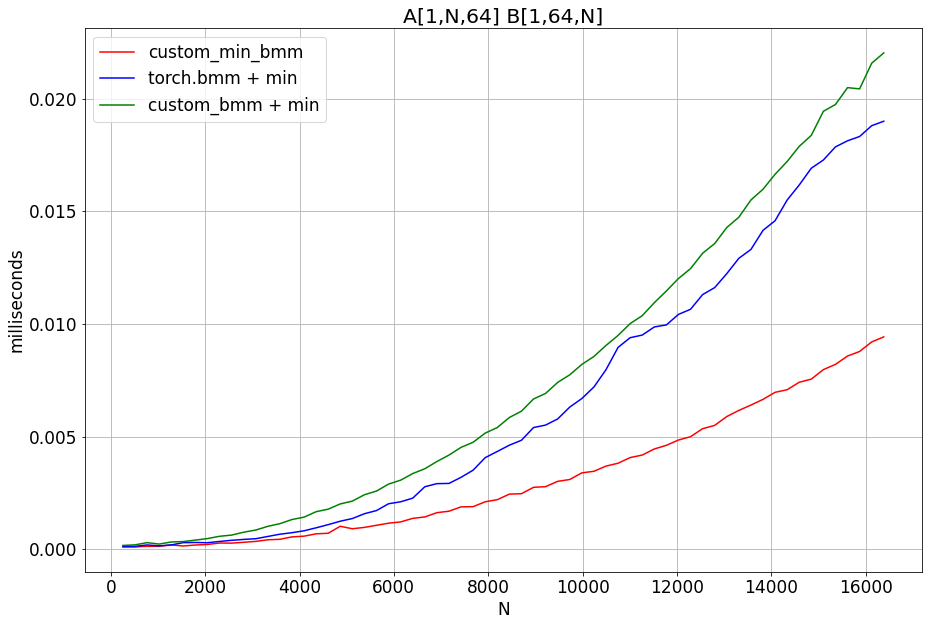

In [ ]:
#@title Grid test MinBMM (Runtime)
ls = [1]
ms = [256*i for i in range(1, 65)]
ns = ms
ks = [64]
mode="nn"

custom_res = dict()
cublass_res = dict()
custommin_res = dict()
for l in ls:
  for m in ms:
    for k in ks:     
      res = test_min_bmm(l, m, m, k, mode=mode, n_iter=25)
      cublass_res[m] = res[0]# *1e3
      custom_res[m] = res[1]# * 1e3
      custommin_res[m] = res[2]#*1e3


plt.figure(figsize=(15, 10) )
plt.tight_layout()
plt.xlabel("N", fontsize=17)
plt.ylabel("milliseconds", fontsize=17)
title = f"A[{l},N,{k}] B[{l},{k},N]"
plt.title(title)
plt.rcParams["font.size"] = "17"
plt.grid()
colors = ["red", "blue", "green"]
labels = ["custom_min_bmm", "torch.bmm + min", "custom_bmm + min"]
for i, res in enumerate([custom_res, cublass_res, custommin_res]):
  res_x = list(res.keys())
  res_y = list(res.values())
  plt.plot(
    res_x,
    res_y,
    color=colors[i],
    label=labels[i],
  )

plt.legend()
plt.savefig("imgs/min_bmm_" + title)
plt.show()